# Spectroscopic selection degrader to emulate zCOSMOS training samples

The spectroscopic_selection degrader can be used to model the spectroscopic success rates in training sets based on real data.  Given a 2-dimensional grid of spec-z success ratio as a function of two variables (often magnitude, color, or redshift), the degrader will draw the appropriate fraction of samples from the input data and return a sample with incompleteness modeled.  

The degrader takes the following arguments:
- `N_tot`: number of selected sources <br>
- `nondetect_val`: non detected magnitude value to be excluded (usually 99.0, -99.0 or NaN).<br>
- `downsample`: If true, downsample the selected sources into a total number of N_tot. <br>
- `success_rate_dir`: The path to the directory containing success rate files.
- `colnames`: a dictionary that includes necessary columns (magnitudes, colors and redshift) for selection. For magnitudes, the keys are ugrizy; for colors, the keys are, for example, gr standing for g-r; for redshift, the key is 'redshift'. 

In this quick notebook we'll select galaxies based on zCOSMOS selection function.

In [1]:
import rail
import os
import matplotlib.pyplot as plt
import numpy as np
import tables_io
import pandas as pd
#from rail.core.data import TableHandle
from rail.core.stage import RailStage
%matplotlib inline 

/net/home/fohlen13/yanza21/anaconda3/envs/rail/lib/python3.8/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '
/net/home/fohlen13/yanza21/anaconda3/envs/rail/lib/python3.8/site-packages/jax/experimental/stax.py:28: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  warnings.warn('jax.experimental.stax is deprecated, '
/net/home/fohlen13/yanza21/anaconda3/envs/rail/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
DS = RailStage.data_store
DS.__class__.allow_overwrite = True

Let's make fake data for zCOSMOS selection. 

In [3]:
i = np.random.uniform(low=18, high=25.9675, size=(2000000,))
gz = np.random.uniform(low=-1.98, high=5.98, size=(2000000,))
u = np.full_like(i, 20.0, dtype=np.double)
g = np.full_like(i, 20.0, dtype=np.double)
r = np.full_like(i, 20.0, dtype=np.double)
y = np.full_like(i, 20.0, dtype=np.double)
z = g - gz
redshift = np.random.uniform(size=len(i)) * 2

standardize the column names

In [4]:
mockdict = {}
for label, item in zip(['u', 'g','r','i', 'z','y', 'redshift'], [u,g,r,i,z,y, redshift]):
    mockdict[f'{label}'] = item

np.repeat(item, 100).flatten()

In [5]:
df = pd.DataFrame(mockdict)

In [6]:
df.head()

,u,g,r,i,z,y,redshift
0,20.0,20.0,20.0,21.608052,17.256106,20.0,0.601622
1,20.0,20.0,20.0,18.035623,14.795550,20.0,0.367423
2,20.0,20.0,20.0,20.508019,16.842229,20.0,0.125606
3,20.0,20.0,20.0,22.863798,14.556936,20.0,0.169077
4,20.0,20.0,20.0,25.918845,21.892444,20.0,1.602153


Now, let's import the spectroscopic_selections degrader for zCOSMOS. <br>
The ratio file for zCOSMOS is located in the `RAIL/examples/creation/data` directory, as we are in `RAIL/examples/creation` folder named `zCOSMOS_success.txt`; the binning in i band and redshift are given in `zCOSMOS_I_sampling.txt` and `zCOSMOS_z_sampling.txt`.<br>
We will set a random seed for reproducibility, and set the output file to write our incomplete catalog to "test_hsc.pq".

In [7]:
import sys
sys.path.append('/net/home/fohlen13/yanza21/research/src/RAIL_May5/RAIL/rail/creation/degradation')
import spectroscopic_selections
from importlib import reload
#reload(spectroscopic_selections_new)
from spectroscopic_selections import SpecSelection_zCOSMOS

In [8]:
zcosmos_selecter = SpecSelection_zCOSMOS.make_stage(downsample=False, 
                                                    colnames={'i':'i','redshift':'redshift'})

Let's run the code and see how long it takes:

In [9]:
%%time
trim_data = zcosmos_selecter(df)

Inserting handle into data store.  input: None, specselection_zCOSMOS
Inserting handle into data store.  output: inprogress_output.pq, specselection_zCOSMOS
CPU times: user 3.68 s, sys: 5.61 ms, total: 3.68 s
Wall time: 3.64 s


In [10]:
trim_data.data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 503967 entries, 0 to 1999999
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   u         503967 non-null  float64
 1   g         503967 non-null  float64
 2   r         503967 non-null  float64
 3   i         503967 non-null  float64
 4   z         503967 non-null  float64
 5   y         503967 non-null  float64
 6   redshift  503967 non-null  float64
dtypes: float64(7)
memory usage: 30.8 MB


And we see that we've kept 503967 out of the 2,000,000 galaxies in the initial sample, so about 25% of the initial sample.  To visualize our cuts, let's read in the success ratios file and plot our sample overlaid with an alpha of 0.05, that way the strength of the black dot will give a visual indication of how many galaxies in each cell we've kept.

In [11]:
# compare to sum of ratios * 100
ratio_file='../../examples/creation/data/success_rate_data/zCOSMOS_success.txt'

In [12]:
ratios = np.loadtxt(ratio_file)

In [13]:
bgr, bi = np.meshgrid(np.linspace(-2, 6, 201), np.linspace(13, 26, 201))

In [14]:
ibin_ = np.loadtxt('../../examples/creation/data/success_rate_data/zCOSMOS_I_sampling.txt')
zbin_ = np.loadtxt('../../examples/creation/data/success_rate_data/zCOSMOS_z_sampling.txt')

ibin, zbin = np.meshgrid(ibin_, zbin_)

In [15]:
trim_data.data

,u,g,r,i,z,y,redshift
0,20.0,20.0,20.0,21.608052,17.256106,20.0,0.601622
1,20.0,20.0,20.0,18.035623,14.795550,20.0,0.367423
2,20.0,20.0,20.0,20.508019,16.842229,20.0,0.125606
5,20.0,20.0,20.0,22.155690,14.762925,20.0,1.201553
7,20.0,20.0,20.0,18.417438,20.662582,20.0,0.401905
...,...,...,...,...,...,...,...
1999969,20.0,20.0,20.0,20.612959,21.053388,20.0,0.537587
1999978,20.0,20.0,20.0,19.503473,21.386000,20.0,0.293330
1999987,20.0,20.0,20.0,22.324742,19.864208,20.0,1.347066
1999989,20.0,20.0,20.0,20.665312,14.531765,20.0,1.011998


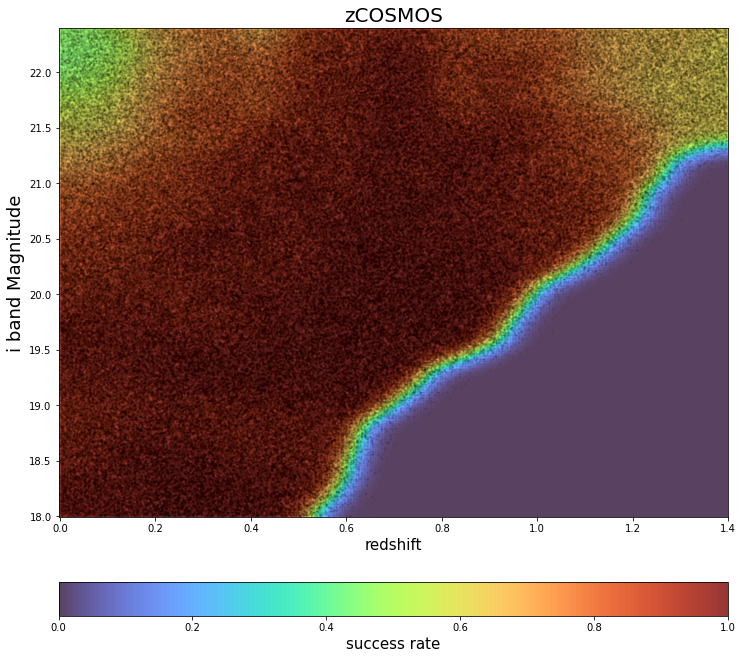

In [16]:
plt.figure(figsize=(12,12))
plt.title('zCOSMOS', fontsize=20)

c = plt.pcolormesh(zbin, ibin, ratios.T, cmap='turbo',vmin=0, vmax=1, alpha=0.8)
plt.scatter(trim_data.data['redshift'], trim_data.data['i'], s=2, c='k',alpha =.05)
plt.xlabel("redshift", fontsize=15)
plt.ylabel("i band Magnitude", fontsize=18)
cb = plt.colorbar(c, label='success rate',orientation='horizontal', pad=0.1)
cb.set_label(label='success rate', size=15)

The colormap shows the zCOSMOS success ratios and the strenth of the black dots shows how many galaxies were actually kept. We see perfect agreement between our predicted ratios and the actual number of galaxies kept, the degrader is functioning properly, and we see a nice visual representation of the resulting spectroscopic sample incompleteness.